In [1]:
%matplotlib inline

import subprocess
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
plt.style.use('ggplot')

from pylab import rcParams
rcParams['figure.figsize'] = (10, 6)

import matplotlib
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 17}
matplotlib.rc('font', **font)

import warnings
warnings.filterwarnings("ignore")

# Загрузка PLAID

In [2]:
# functions to read data and meta data
def read_data_given_id(path,ids,progress=True,last_offset=0):
    '''read data given a list of ids and CSV paths'''
    start = datetime.now()
    n = len(ids)
    if n == 0:
        return {}
    else:
        data = {}
        for (i,ist_id) in enumerate(ids, start=1):
            if progress and np.mod(i,np.ceil(n/10))==0:
                print('%d/%d (%2.0f%s) have been read...\t time consumed: %ds'\
                      %(i,n,i/n*100,'%',(datetime.now()-start).seconds))
            if last_offset==0:
                data[ist_id] = np.genfromtxt(path+str(ist_id)+'.csv',delimiter=',',\
                                         names='current,voltage',dtype=(float,float))
            else:
                p=subprocess.Popen(['tail','-'+str(int(last_offset)),path+str(ist_id)+'.csv'],\
                                   stdout=subprocess.PIPE)
                data[ist_id] = np.genfromtxt(p.stdout,delimiter=',',names='current,voltage',dtype=(float,float))
        print('%d/%d (%2.0f%s) have been read(Done!) \t time consumed: %ds'\
            %(n,n,100,'%',(datetime.now()-start).seconds)) 
        return data

In [3]:
import json

Data_path = '../PLAID_s'
csv_path = Data_path + '/submetered/submetered_new/'
#csv_path = Data_path + '/aggregated/'

# # read meta
with open(Data_path + '/metadata_submetered.json') as data_file:    
     meta1 = json.load(data_file)

In [4]:
IDs_for_read_data = list(meta1.keys())
Types = [meta1[key]['appliance']['type'] for key in IDs_for_read_data]
Unq_type = list(set(Types))
Unq_type.sort()
Locs = [meta1[key]['header']['collection_time'] + '_' + meta1[key]['location'] for key in meta1.keys()]
Unq_loc = list(set(Locs))
Unq_loc.sort()
Original_Unq_type = Unq_type

In [5]:
print('Number of households: %d\nNumber of total measurements:%d'%(len(Unq_loc),len(Locs)))

Number of households: 65
Number of total measurements:1876


In [6]:
# read data
# estimated time cost:  ~ 1 mins
npts = 10000
Data = read_data_given_id(csv_path,IDs_for_read_data,progress=True, last_offset=npts)

188/1876 (10%) have been read...	 time consumed: 4s
376/1876 (20%) have been read...	 time consumed: 9s
564/1876 (30%) have been read...	 time consumed: 14s
752/1876 (40%) have been read...	 time consumed: 19s
940/1876 (50%) have been read...	 time consumed: 24s
1128/1876 (60%) have been read...	 time consumed: 29s
1316/1876 (70%) have been read...	 time consumed: 35s
1504/1876 (80%) have been read...	 time consumed: 41s
1692/1876 (90%) have been read...	 time consumed: 46s
1876/1876 (100%) have been read(Done!) 	 time consumed: 52s


In [7]:
print('Total number of instances:%d'%len(Data))

Total number of instances:1876


In [8]:
Data['1']['current']

array([-0.57, -0.55, -0.54, ..., -0.69, -0.7 , -0.67])

In [9]:
Data['3']['current']

array([0.15, 0.23, 0.44, ..., 0.04, 0.04, 0.04])

In [10]:
fs = 30000
f0 = 60
NS = fs//f0 # number of samples per period
NP = npts//NS # number of periods for npts

# calculate the representative one period of steady state 
# (mean of the aggregated signals over one cycle)
n = len(Data)
rep_I = np.empty([n,NS])
rep_V = np.empty([n,NS])
for i in range(n):
    tempI = np.sum(np.reshape(Data[str(i+1)]['current'],[NP,NS]),0)/NP
    tempV = np.sum(np.reshape(Data[str(i+1)]['voltage'],[NP,NS]),0)/NP
    # align current to make all samples start from 0 and goes up
    ix = np.argsort(np.abs(tempI))
    j = 0
    while True:
        if ix[j]<499 and tempI[ix[j]+1]>tempI[ix[j]]:
            real_ix = ix[j]
            break
        else:
            j += 1
    rep_I[i,] = np.hstack([tempI[real_ix:],tempI[:real_ix]])
    rep_V[i,] = np.hstack([tempV[real_ix:],tempV[:real_ix]])

In [11]:
type_Ids = {}
loc_Ids = {}
n = len(Data)
type_label = np.zeros(n,dtype='int')
loc_label = np.zeros(n,dtype='int')
for (ii, t) in enumerate(Unq_type):
    type_Ids[t] = [i-1 for i,j in enumerate(Types,start=1) if j == t]
    type_label[type_Ids[t]] = ii + 1
for (ii, t) in enumerate(Unq_loc):
    loc_Ids[t] = [i-1 for i,j in enumerate(Locs,start=1) if j == t]
    loc_label[loc_Ids[t]] = ii + 1
print('number of different types: %d'% len(Unq_type))
print('number of different households: %d'% len(Unq_loc))

number of different types: 16
number of different households: 65


['Air Conditioner', 'Blender', 'Coffee maker', 'Compact Fluorescent Lamp', 'Fan', 'Fridge', 'Hair Iron', 'Hairdryer', 'Heater', 'Incandescent Light Bulb', 'Laptop', 'Microwave', 'Soldering Iron', 'Vacuum', 'Washing Machine', 'Water kettle']
Similified verstion:
['AC', 'CFL', 'Coffee maker', 'Compact Fluorescent Lamp', 'Fan', 'Fridge', 'Bulb', 'Hairdryer', 'Heater', 'Incandescent Light Bulb', 'Washer', 'Microwave', 'Soldering Iron', 'Vacuum', 'Washing Machine', 'Water kettle']


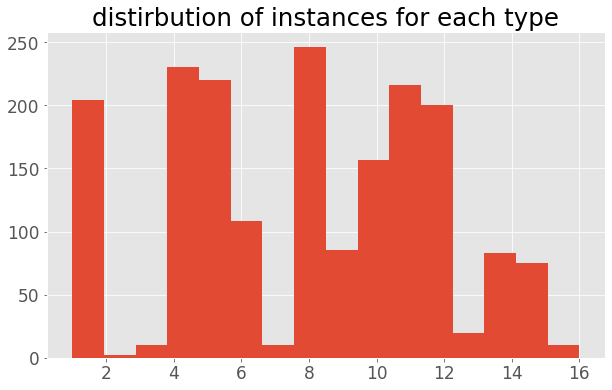

In [12]:
plt.hist(type_label,len(Unq_type))
plt.title('distirbution of instances for each type')
print(Original_Unq_type)
print('Similified verstion:')
Unq_type[0]='AC';
Unq_type[1]='CFL';
Unq_type[6]='Bulb';
Unq_type[10]='Washer';
print(Unq_type)
plt.savefig('type_dist.eps', format='eps')

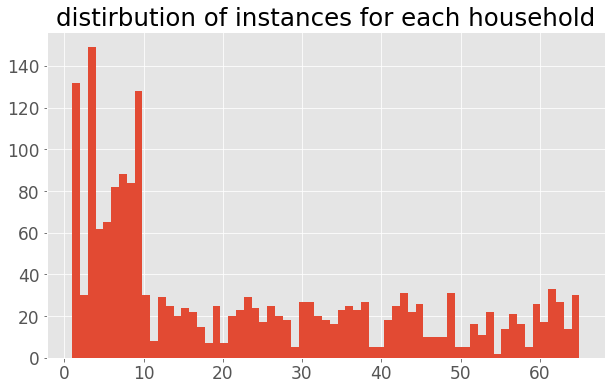

In [13]:
plt.hist(loc_label,len(Unq_loc))
plt.title('distirbution of instances for each household')
plt.savefig('house_dist.eps', format='eps')

# Линейные модели

In [14]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_curve

def myclassifiers(X_train,y_train,X_test,y_test,verbose=False):
    
    knn = KNeighborsClassifier(n_neighbors=1)
    gnb = GaussianNB()
    logistic = LogisticRegression(C=1e5)
    svc = svm.SVC(kernel='rbf',gamma=.7,C=1.0)
    lda = LDA(solver='lsqr', shrinkage='auto')
    qda = QDA()
    dTree = tree.DecisionTreeClassifier(max_depth=10)
    rForest = RandomForestClassifier(max_depth=10,n_estimators=20)
    adaBoost = AdaBoostClassifier()
    
    
    names = ["Nearest Neighbors(k=1)", "Naive Bayes","Logistic","RBF SVM", "LDA", "QDA",
             "Decision Tree","Random Forest", "AdaBoost"]
    classifiers = [knn, gnb, logistic, svc, lda, qda, dTree, rForest, adaBoost]
    y_predict = []
    acc = []
#     print('Running',end="")
    for (i,clf) in enumerate(classifiers):
        if verbose:
            print(' %s... '% names[i],end="")
        clf.fit(X_train,y_train)
        y_predict.append(clf.predict(X_test))
        acc.append(clf.score(X_test,y_test))
    return (acc,y_predict,names)

In [15]:
rep_I.shape, rep_V.shape

((1876, 500), (1876, 500))

In [16]:
rep_I[4].shape

(500,)

In [297]:
X_train, X_test, y_train, y_test = train_test_split(rep_V[3:,:], type_label[3:], test_size=0.1, random_state=0)
(acc, y_p, names) = myclassifiers(X_train, y_train, X_test, y_test)

In [18]:
# точность для линейных моделей в порядке names
acc

[0.9680851063829787,
 0.5638297872340425,
 0.3776595744680851,
 0.11702127659574468,
 0.4308510638297872,
 0.3617021276595745,
 0.8723404255319149,
 0.9202127659574468,
 0.17553191489361702]

# CNN по напряжению

In [ ]:
!pip install keras
!pip install tensorflow

In [298]:
import pywt
from collections import defaultdict, Counter
import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History 

In [299]:
X_train.shape

(1685, 500)

In [300]:
X_train[0].shape

(500,)

In [301]:
img_x = 25
img_y = 10
img_z = 2

num_classes = 17

x_train = X_train.reshape(X_train.shape[0], img_x, img_y, img_z)

In [302]:
rep_I.shape

(1876, 500)

In [303]:
x_test = X_test.reshape(X_test.shape[0], img_x, img_y, img_z)

In [304]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (1685, 25, 10, 2)
1685 train samples
188 test samples


In [305]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [315]:
input_shape = (img_x, img_y, img_z)
batch_size = 250
epochs = 100
history = History()

model = Sequential()
model.add(Conv2D(32, kernel_size=(2, 2), strides=(1, 1), activation='relu', input_shape=input_shape)) 
model.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model_VI_image.add(Dropout(0.5, input_shape=(1,)))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=batch_size, 
          epochs=epochs, verbose=1, 
          validation_data=(x_test, y_test), 
          callbacks=[history])

train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Epoch 1/100
7/7 [==============================] - 1s 134ms/step - loss: 101.2578 - accuracy: 0.1205 - val_loss: 126.4823 - val_accuracy: 0.2021
Epoch 2/100
7/7 [==============================] - 1s 124ms/step - loss: 90.0003 - accuracy: 0.1855 - val_loss: 44.4330 - val_accuracy: 0.3032
Epoch 3/100
7/7 [==============================] - 1s 128ms/step - loss: 27.2373 - accuracy: 0.2710 - val_loss: 9.7072 - val_accuracy: 0.3777
Epoch 4/100
7/7 [==============================] - 1s 117ms/step - loss: 6.2094 - accuracy: 0.3316 - val_loss: 2.2840 - val_accuracy: 0.2287
Epoch 5/100
7/7 [==============================] - 1s 119ms/step - loss: 1.9031 - accuracy: 0.3825 - val_loss: 1.7156 - val_accuracy: 0.4255
Epoch 6/100
7/7 [==============================] - 1s 119ms/step - loss: 1.5611 - accuracy: 0.4274 - val_loss: 1.6595 - val_accuracy: 0.3032
Epoch 7/100
7/7 [==============================] - 1s 120ms/step - loss: 1.4424 - accuracy: 0.4485 - val_loss: 1.5055 - val_accuracy: 0.4947
Epoch 

Epoch 59/100
7/7 [==============================] - 1s 116ms/step - loss: 0.5996 - accuracy: 0.7801 - val_loss: 0.7939 - val_accuracy: 0.7128
Epoch 60/100
7/7 [==============================] - 1s 117ms/step - loss: 0.5758 - accuracy: 0.7718 - val_loss: 0.7813 - val_accuracy: 0.7128
Epoch 61/100
7/7 [==============================] - 1s 116ms/step - loss: 0.5630 - accuracy: 0.7914 - val_loss: 0.7509 - val_accuracy: 0.7447
Epoch 62/100
7/7 [==============================] - 1s 115ms/step - loss: 0.5270 - accuracy: 0.8137 - val_loss: 0.8107 - val_accuracy: 0.7074
Epoch 63/100
7/7 [==============================] - 1s 115ms/step - loss: 0.5408 - accuracy: 0.7996 - val_loss: 0.8277 - val_accuracy: 0.6915
Epoch 64/100
7/7 [==============================] - 1s 115ms/step - loss: 0.5476 - accuracy: 0.7904 - val_loss: 0.7879 - val_accuracy: 0.7394
Epoch 65/100
7/7 [==============================] - 1s 119ms/step - loss: 0.5148 - accuracy: 0.8122 - val_loss: 0.8002 - val_accuracy: 0.6968
Epoch 

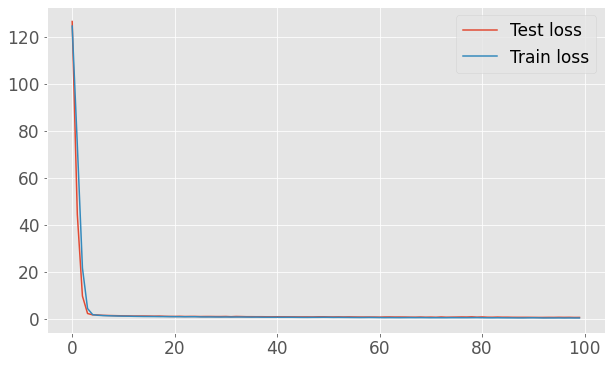

In [320]:
plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Test loss')
plt.plot(history.epoch, np.array(history.history['loss']),
           label = 'Train loss')
plt.legend()
plt.show()

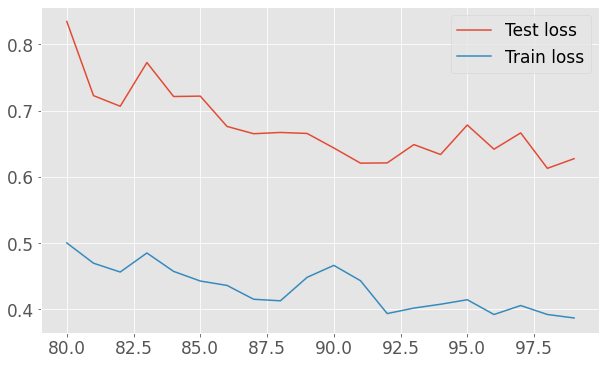

In [319]:
plt.plot(history.epoch[80:100], np.array(history.history['val_loss'][80:100]),
           label = 'Test loss')
plt.plot(history.epoch[80:100], np.array(history.history['loss'][80:100]),
           label = 'Train loss')
plt.legend()
plt.show()

In [317]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

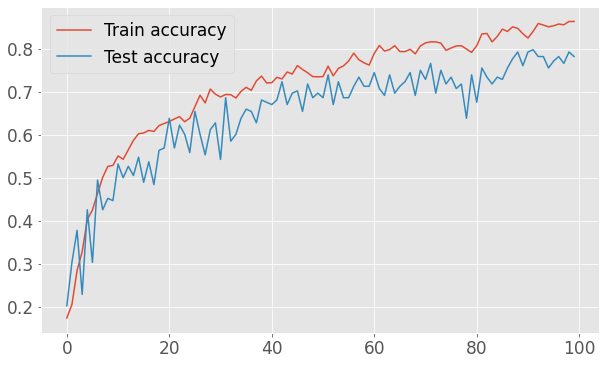

In [318]:
plt.plot(history.epoch, np.array(history.history['accuracy']),
           label = 'Train accuracy')
plt.plot(history.epoch, np.array(history.history['val_accuracy']),
           label = 'Test accuracy')
plt.legend()
plt.show()


# CNN по фигурам Лиссажу

In [42]:
def center(X,w):
    minX = np.amin(X)
    maxX = np.amax(X)
    dist = max(abs(minX),maxX)
    X[X<-dist] = -dist
    X[X>dist] = dist
    d = (maxX-minX)/w
    return (X,d)
    
def get_img_from_VI(V, I, width,hard_threshold=False,para=.5):
    '''Get images from VI, hard_threshold, set para as threshold to cut off,5-10
    soft_threshold, set para to .1-.5 to shrink the intensity'''
    
    d = V.shape[0]
    # doing interploation if number of points is less than width*2
    if d<2* width:
        newI = np.hstack([V, V[0]])
        newV = np.hstack([I, I[0]])
        oldt = np.linspace(0,d,d+1)
        newt = np.linspace(0,d,2*width)
        I = np.interp(newt,oldt,newI)
        V = np.interp(newt,oldt,newV)
    # center the current and voltage, get the size resolution of mesh given width    
    (I,d_c)  = center(I,width)
    (V,d_v)  = center(V,width)
    
    #  find the index where the VI goes through in current-voltage axis
    ind_c = np.floor((I-np.amin(I))/d_c).astype(int)
    ind_v = np.floor((V-np.amin(V))/d_v).astype(int)
    ind_c[ind_c==width] = width-1
    ind_v[ind_v==width] = width-1
    
    Img = np.zeros((width,width))
    
    for i in range(len(I)):
        Img[ind_c[i],width-ind_v[i]-1] += 1
    
    if hard_threshold:
        Img[Img<para] = 0
        Img[Img!=0] = 1
        return Img
    else:
        return (Img/np.max(Img))**para

In [43]:
n = len(Data)
width = 16

Imgs = np.zeros((n,width,width), dtype=np.float64)
for i in range(n):
    Imgs[i,:,:] = get_img_from_VI(rep_V[i,], rep_I[i,], width,True,1)
BinaryF=np.reshape(Imgs,(n,width*width))

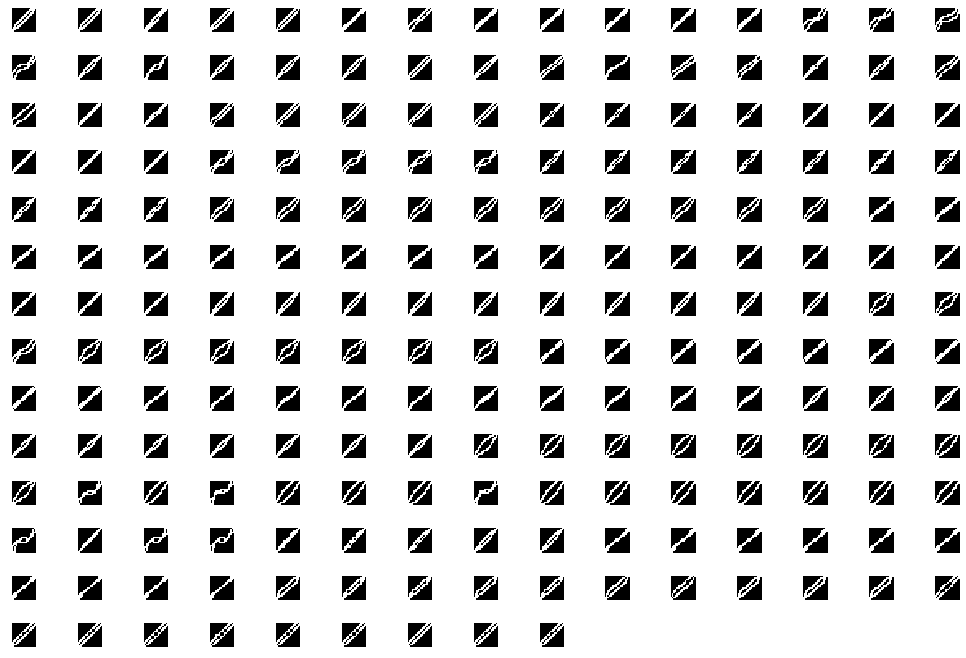

In [44]:
# visualization of all imgaes from certain type in Imgs
type_id = 1
n = sum(type_label==type_id)
fig = plt.figure(figsize=(14,np.ceil(n/15)))
count = 1
for i in np.where(type_label==type_id)[0]:
    plt.subplot(np.ceil(n/10),15,count)
    plt.imshow(Imgs[i,:,:],cmap = cm.Greys_r,interpolation='None')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
#     plt.title('Id: '+str(k),fontsize=10)
    count += 1
fig.tight_layout()
plt.show()

In [48]:
print('type label:',type_label)
print('location label:', loc_label)
print('number of different types: %d\n'% len(Unq_type),Unq_type)
print('number of different households: %d\b'% len(Unq_loc))

type label: [ 4  4  4 ... 13  2  2]
location label: [11 11 11 ...  1  1  1]
number of different types: 16
 ['AC', 'CFL', 'Coffee maker', 'Compact Fluorescent Lamp', 'Fan', 'Fridge', 'Bulb', 'Hairdryer', 'Heater', 'Incandescent Light Bulb', 'Washer', 'Microwave', 'Soldering Iron', 'Vacuum', 'Washing Machine', 'Water kettle']
number of different households: 65


In [217]:
X_train_VI_image, X_test_VI_image, y_train_VI_image, y_test_VI_image = train_test_split(BinaryF, type_label, test_size=0.1, random_state=42)

In [218]:
X_train_VI_image.shape

(1688, 256)

In [219]:
y_train_VI_image.shape

(1688,)

In [289]:
history_VI_image = History()

In [221]:
img_x_VI = 16
img_y_VI = 8
img_z_VI = 2

num_classes = 17

x_train_VI_image = X_train_VI_image.reshape(X_train_VI_image.shape[0], img_x_VI, img_y_VI, img_z_VI)

In [222]:
y_train_VI_image = keras.utils.to_categorical(y_train_VI_image, num_classes)
y_test_VI_image = keras.utils.to_categorical(y_test_VI_image, num_classes)

In [223]:
x_test_VI_image = X_test_VI_image.reshape(X_test_VI_image.shape[0], img_x_VI, img_y_VI, img_z_VI)

In [270]:
x_train_VI_image.shape

(1688, 16, 8, 2)

In [225]:
y_train_VI_image.shape

(1688, 17)

In [226]:
y_test_VI_image.shape

(188, 17)

In [290]:
from keras.layers import Dropout

input_sh_VI_image = (img_x_VI, img_y_VI, img_z_VI)
epochs = 100
batch_size = 300

model_VI_image = Sequential()
model_VI_image.add(Conv2D(32, kernel_size=(2, 2), strides=(1, 1), activation='relu', input_shape=input_sh_VI_image)) 
model_VI_image.add(MaxPooling2D(pool_size=(3, 3), strides=(1, 1)))
model_VI_image.add(Conv2D(64, (5, 5), activation='relu'))
model_VI_image.add(MaxPooling2D(pool_size=(1, 1)))
model_VI_image.add(Flatten())
model_VI_image.add(Dense(2000, activation='relu'))
model_VI_image.add(Dropout(0.5, input_shape=(1,)))
model_VI_image.add(Dense(num_classes, activation='softmax'))

model_VI_image.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])

model_VI_image.fit(x_train_VI_image, y_train_VI_image, batch_size=batch_size, 
          epochs=epochs, verbose=1, 
          validation_data=(x_test_VI_image, y_test_VI_image), 
          callbacks=[history_VI_image])

train_score = model_VI_image.evaluate(x_train_VI_image, y_train_VI_image, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model_VI_image.evaluate(x_test_VI_image, y_test_VI_image, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Epoch 1/100
6/6 [==============================] - 1s 54ms/step - loss: 2.5344 - accuracy: 0.2067 - val_loss: 1.9720 - val_accuracy: 0.3723
Epoch 2/100
6/6 [==============================] - 0s 40ms/step - loss: 1.8294 - accuracy: 0.4099 - val_loss: 1.5597 - val_accuracy: 0.5532
Epoch 3/100
6/6 [==============================] - 0s 40ms/step - loss: 1.4519 - accuracy: 0.5202 - val_loss: 1.2862 - val_accuracy: 0.6755
Epoch 4/100
6/6 [==============================] - 0s 39ms/step - loss: 1.2716 - accuracy: 0.5752 - val_loss: 1.0383 - val_accuracy: 0.6968
Epoch 5/100
6/6 [==============================] - 0s 42ms/step - loss: 1.0658 - accuracy: 0.6475 - val_loss: 0.9357 - val_accuracy: 0.7181
Epoch 6/100
6/6 [==============================] - 0s 39ms/step - loss: 0.9995 - accuracy: 0.6557 - val_loss: 0.8510 - val_accuracy: 0.7340
Epoch 7/100
6/6 [==============================] - 0s 42ms/step - loss: 0.8665 - accuracy: 0.6901 - val_loss: 0.8359 - val_accuracy: 0.7234
Epoch 8/100
6/6 [===

6/6 [==============================] - 0s 39ms/step - loss: 0.2863 - accuracy: 0.9152 - val_loss: 0.4777 - val_accuracy: 0.8777
Epoch 60/100
6/6 [==============================] - 0s 39ms/step - loss: 0.2873 - accuracy: 0.9028 - val_loss: 0.5010 - val_accuracy: 0.8723
Epoch 61/100
6/6 [==============================] - 0s 35ms/step - loss: 0.3132 - accuracy: 0.9052 - val_loss: 0.5266 - val_accuracy: 0.8670
Epoch 62/100
6/6 [==============================] - 0s 40ms/step - loss: 0.2892 - accuracy: 0.9173 - val_loss: 0.5014 - val_accuracy: 0.8777
Epoch 63/100
6/6 [==============================] - 0s 36ms/step - loss: 0.2735 - accuracy: 0.9211 - val_loss: 0.4742 - val_accuracy: 0.8830
Epoch 64/100
6/6 [==============================] - 0s 39ms/step - loss: 0.2842 - accuracy: 0.9142 - val_loss: 0.4932 - val_accuracy: 0.8883
Epoch 65/100
6/6 [==============================] - 0s 37ms/step - loss: 0.2728 - accuracy: 0.9187 - val_loss: 0.4923 - val_accuracy: 0.8830
Epoch 66/100
6/6 [========

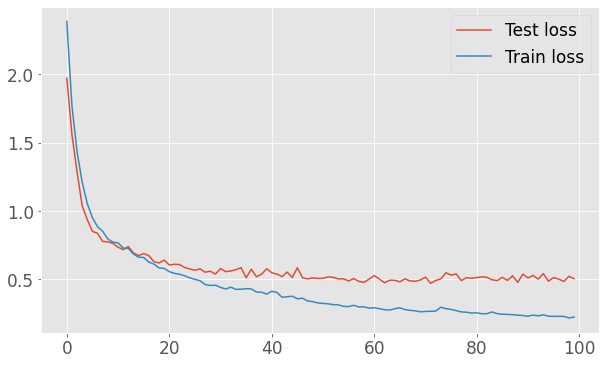

In [291]:
plt.plot(history_VI_image.epoch, np.array(history_VI_image.history['val_loss']),
           label = 'Test loss')
plt.plot(history_VI_image.epoch, np.array(history_VI_image.history['loss']),
           label = 'Train loss')
plt.legend()
plt.show()

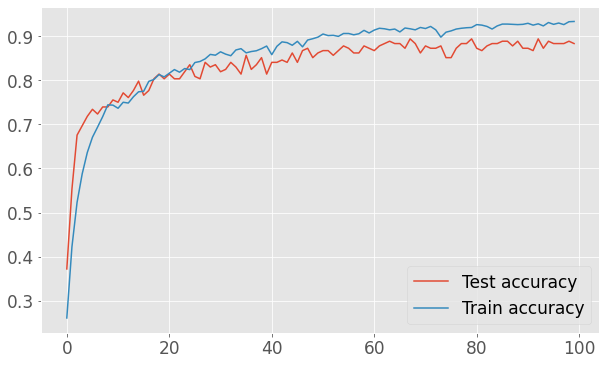

In [292]:
plt.plot(history_VI_image.epoch, np.array(history_VI_image.history['val_accuracy']),
           label = 'Test accuracy')
plt.plot(history_VI_image.epoch, np.array(history_VI_image.history['accuracy']),
           label = 'Train accuracy')
plt.legend()
plt.show()